# Example of each Unit of the Congestion Finder

This Notebook documents all the classes and functions of the _congestion finder_ module. It shows how these work by giving short examples.

## Initialisation

The Notebook is initialised by loading all required modules and turning on logging.

### Imports

The following modules are required for this Notebook. The _congestion finder_ module lives in the parent directory of this _documentation_ directory, so we need to append that directory to the _system path_.

In [19]:
import numpy
import matplotlib.pyplot

import logging
import io
import re
import ast

import sys
sys.path.append("../")
import congestionfinder
import congestionfinder.bpsdetector
import congestionfinder.road
import congestionfinder.detection
import congestionfinder.speedflow
import congestionfinder.congestion
import patchfinder.patch

### Logging

To see what is going on while the functions are called, logging is turned on. It is set to _debug_ level. In the _patch finder_ function, it is also useful to extract specific logging information to build plots. Therefore, a second logger is introduced with a filter for these patches. This logger prints directly into a string variable.

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(formatter)
logger.addHandler(consoleHandler)

class PlotFilter(logging.Filter):
    def filter(self, record):
        return "Found patches:" in record.getMessage()

log_capture_string = io.StringIO()
variableHandler = logging.StreamHandler(log_capture_string)
variableHandler.addFilter(PlotFilter())
logger.addHandler(variableHandler)

## Classes

The following classes contain objects and functions.

### BPS Detectors

A _BPSDetector_ can be identified using a 20-digit hexadecimal number. This number encodes all relevant information. The _constructor_ of the _BPSDetector_ object takes this number and parses it.

In [36]:
bpsDetector = congestionfinder.bpsdetector.BPSDetector("00D00C03405B18200005")
print(bpsDetector)

bpsCode: 00D00C03405B18200005 | roadNumber: 12 | hectometer: 208 | additionalMeters: 91


### Roads

A _Road_ can be identified by its number. Each road contains a set of _BPSDetectors_. Therefore, the _Road_ object contains a function to add a _BPSDetector_. These _BPSDetectors_ can be ordered in space, along the road. Once all _BPSDetectors_ have been added to the _Road_, this set can be ordered into an index. The _Road_ object contains a function to do this.

In [4]:
road = congestionfinder.road.Road(12)
road.addBPSDetector(bpsDetector)
print(road)
road.indexDetectorSpaces()
print(road.getSpaceToSpaceIndex())

roadNumber: 12 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 0
{20891: 0}


As _Roads_ are essentially a specific lists of _BPSDetectors_, the _Road_ object contains a function which can parse a set of _BPS codes_ directly to a set of _Roads_ via the _constructor_ of the _BPSDetector_ object.

In [47]:
roads = congestionfinder.road.parseBPSCodesToRoads(["10D00204C00038200005", "10D00204D037D007000B", "10D002051800D0070013", "10D002057000D007000F"])
for value in roads.values():
    value.indexDetectorSpaces()

2018-01-03 10:53:03,047 - DEBUG - Starting parseBPSCodesToRoads()
2018-01-03 10:53:03,047 - DEBUG - Ending parseBPSCodesToRoads()


The following prints the resulting set of _Roads_, which in this example consists of 1 _Road_ with 4 _BPSDetectors_.

In [48]:
for road in roads.values():
    print(road)

roadNumber: 2 | len(bpsDetectors): 4 | len(spaceToSpaceIndex): 4


### Detections

A _Detection_ consists of a measurement of average speed and average flow at a specific location and time. The _Detection_ object takes a _BPS code_, a space and time location and the speed and flow data.

In [5]:
detection = congestionfinder.detection.Detection("00D00C03405B18200005", 1234, 1440, 120, 17)
print(detection)

code: 00D00C03405B18200005 | space: 1234 | time: 1440 | speed: 120 | flow: 17


### Speed and Flows

A set of _Detections_ along a road can be parsed into two arrays or speed and flow.

In [67]:
detections = []
detections.append(congestionfinder.detection.Detection("10D00204C00038200005", 30400, 1, 100, 1))
detections.append(congestionfinder.detection.Detection("10D00204C00038200005", 30400, 2, 85, 20))
detections.append(congestionfinder.detection.Detection("10D00204C00038200005", 30400, 3, 80, 17))
detections.append(congestionfinder.detection.Detection("10D00204C00038200005", 30400, 4, 70, 15))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 1, 100, 1))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 2, 55, 18))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 3, 35, 12))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 4, 40, 14))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 1, 95, 1))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 2, 85, 14))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 3, 100, 19))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 4, 90, 16))

The _SpeedFlow_ object contains a function which parses a set of _Detections_ into such arrays. It uses information about the sturcture of the _Road_ to map the _Detections_ to the right location. It also gives the boundaries in space and in time of these arrays. In real life, it may occur that a _BPSDetector_ is out of order. In this case, no information from that location is known. As such, the speed and flow data may contain gaps and its boundaries may not be the same as the start and finish of the road.

In [68]:
speeds, flows, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex = congestionfinder.speedflow.parseDetectionsToSpeedsAndFlows(detections, roads[2])

2018-01-03 10:58:33,713 - DEBUG - Starting parseDetectionsToSpeedFlows()
2018-01-03 10:58:33,713 - DEBUG - Ending parseDetectionsToSpeedFlows()


In this example, this speed and flow arrays are both 4 by 4 matrices. A plot shows the matrices.

(4, 4)
(4, 4)
0
3
1
4


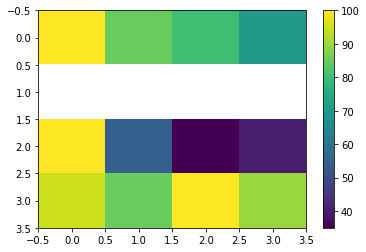

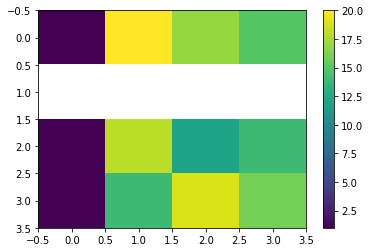

In [69]:
print(speeds.shape)
print(flows.shape)
print(minSpaceIndex)
print(maxSpaceIndex)
print(minTimeIndex)
print(maxTimeIndex)
matplotlib.pyplot.imshow(speeds, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flows, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

As mentioned, a _BPSDetector_ may be out of order in real life. The _SpeedFlow_ object contains a function which can remove such locations. It returns trimmed arrays for speed and flow data, and a mask which can be used to identify the space index with the original spatial location of the _Detection_.

In [72]:
speedsWorkingDetectors, flowsWorkingDetectors, maskWorkingDetectors = congestionfinder.speedflow.removeMissingDetectors(speeds, flows)

2018-01-03 11:00:28,212 - DEBUG - Starting removeMissingDetectors()
2018-01-03 11:00:28,212 - DEBUG - Ending removeMissingDetectors()


In this example, there is missing detector at space index 1 which can be removed. The resulting arrays are both 4 by 3 matrices. A plot shows the matrices.

(3, 4)
(3, 4)
0.75


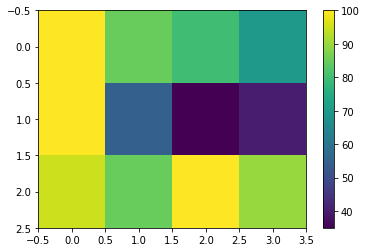

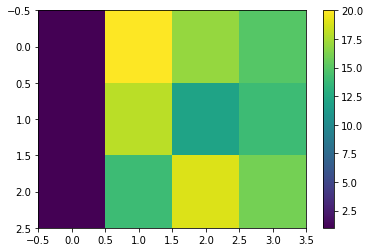

In [73]:
print(speedsWorkingDetectors.shape)
print(flowsWorkingDetectors.shape)
print(sum(maskWorkingDetectors) / (sum(maskWorkingDetectors) + sum(~maskWorkingDetectors)))
matplotlib.pyplot.imshow(speedsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

Not all detection data is reliable or relevant. When the flow is low, the measurements of average speed are less accurate. Furthermore, when the flow is low, there is no possibility for congestion. Low flow occurs consistently at specific times, such as during the night. The _SpeedFlow_ object contains a function which can remove such low flow times. It returns trimmed arrays for speed and flow data, and a mask which can be used to identify the time index with the original temporal location of the _Detection_.

In [76]:
speedsHighFlow, flowsHighFlow, maskHighFlow = congestionfinder.speedflow.removeLowFlowTimes(speedsWorkingDetectors, flowsWorkingDetectors)

2018-01-03 11:02:55,501 - DEBUG - Starting removeLowFlowTimes()
2018-01-03 11:02:55,501 - DEBUG - Ending removeLowFlowTimes()


In this example, there is low flow at time index 0. The resulting arrays are both 3 by 3 matrices. A plot shows the matrices.

(3, 3)
(3, 3)
0.75


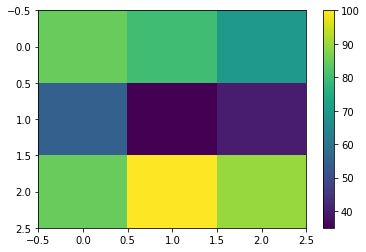

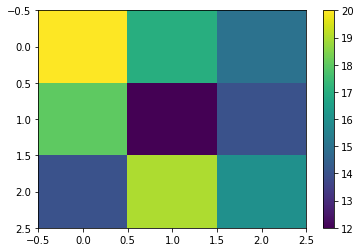

In [75]:
print(speedsHighFlow.shape)
print(flowsHighFlow.shape)
print(sum(maskHighFlow) / (sum(maskHighFlow) + sum(~maskHighFlow)))
matplotlib.pyplot.imshow(speedsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

### Congestion (part 1)

.

In [15]:
speedThreshold = 65
flowThreshold = 40
congestions = congestionfinder.congestion.parseSpeedFlowsToCongestions(speedsWorkingDetectors, flowsWorkingDetectors, speedThreshold, flowThreshold)

2018-01-03 09:33:19,785 - DEBUG - Starting parseSpeedFlowsToCongestions()
2018-01-03 09:33:19,785 - DEBUG - Ending parseSpeedFlowsToCongestions()


.

(3, 3)


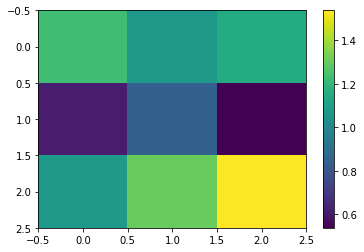

In [16]:
print(congestions.shape)
matplotlib.pyplot.imshow(congestions, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

.

In [20]:
congestions[1, 1] = numpy.nan
congestionsWithoutMissingValues = congestionfinder.congestion.interpolateMissingValues(congestions)

2018-01-03 09:33:42,034 - DEBUG - Starting interpolateMissingValues()
2018-01-03 09:33:42,066 - DEBUG - Ending interpolateMissingValues()


.

(3, 3)


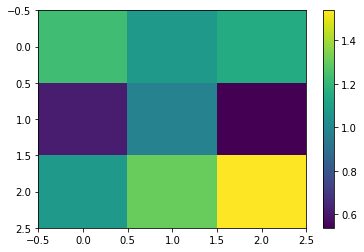

In [21]:
print(congestionsWithoutMissingValues.shape)
matplotlib.pyplot.imshow(congestionsWithoutMissingValues, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

.

In [22]:
spaceSmoothing = 1
timeSmoothing = 2
congestionsSmoothed = congestionfinder.congestion.applySmoothingFilter(congestionsWithoutMissingValues, spaceSmoothing, timeSmoothing)

2018-01-03 09:33:43,582 - DEBUG - Starting applySmoothingFilter()
2018-01-03 09:33:43,597 - DEBUG - Ending applySmoothingFilter()


.

(3, 3)


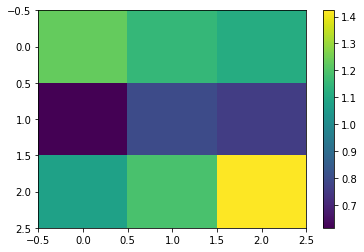

In [23]:
print(congestionsSmoothed.shape)
matplotlib.pyplot.imshow(congestionsSmoothed, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

## Patch Finder

.

In [24]:
testDataArray = numpy.random.rand(16,9)
testBooleanArray = testDataArray >= 0.9
print(testBooleanArray)

[[False False False False False False False False False]
 [False False False False  True  True False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False  True False False False False False False False]
 [False False False False False False False False False]
 [ True False False False False False  True False  True]
 [False False False False False False False False False]
 [False False False  True False False False False False]
 [False False False False False False False False False]
 [False False False False False False False  True False]
 [False False False False  True False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False  True  True False]
 [ True False False False False False False False False]]


.

In [25]:
patches = patchfinder.patch.findPatches(testBooleanArray)

2018-01-03 09:33:47,020 - DEBUG - Starting findPatches()
2018-01-03 09:33:47,020 - DEBUG - Direction: 0
2018-01-03 09:33:47,020 - DEBUG - Starting scanForBoundaries()
2018-01-03 09:33:47,020 - DEBUG - Found start: 0
2018-01-03 09:33:47,020 - DEBUG - Found stop: 1
2018-01-03 09:33:47,020 - DEBUG - Found start: 3
2018-01-03 09:33:47,020 - DEBUG - Found stop at end.
2018-01-03 09:33:47,020 - DEBUG - Ending scanForBoundaries()
2018-01-03 09:33:47,020 - DEBUG - Found patches: [[0, 15, 0, 1], [0, 15, 3, 8]]
2018-01-03 09:33:47,036 - DEBUG - length: 2| parentLength: 0
2018-01-03 09:33:47,036 - DEBUG - Scanning children...
2018-01-03 09:33:47,036 - DEBUG - Child: 0
2018-01-03 09:33:47,036 - DEBUG -   Starting findPatches()
2018-01-03 09:33:47,036 - DEBUG -   Direction: 1
2018-01-03 09:33:47,036 - DEBUG -   Starting scanForBoundaries()
2018-01-03 09:33:47,036 - DEBUG -   Found start: 4
2018-01-03 09:33:47,036 - DEBUG -   Found stop: 4
2018-01-03 09:33:47,036 - DEBUG -   Found start: 6
2018-01-0

2018-01-03 09:33:47,176 - DEBUG -     length: 2| parentLength: 5
2018-01-03 09:33:47,176 - DEBUG -     Scanning children...
2018-01-03 09:33:47,176 - DEBUG -     Child: 0
2018-01-03 09:33:47,176 - DEBUG -       Starting findPatches()
2018-01-03 09:33:47,176 - DEBUG -       Direction: 1
2018-01-03 09:33:47,176 - DEBUG -       Starting scanForBoundaries()
2018-01-03 09:33:47,176 - DEBUG -       Length is one
2018-01-03 09:33:47,176 - DEBUG -       Ending scanForBoundaries()
2018-01-03 09:33:47,176 - DEBUG -       Found patches: [[6, 6, 6, 6]]
2018-01-03 09:33:47,176 - DEBUG -       length: 1| parentLength: 2
2018-01-03 09:33:47,176 - DEBUG -       Scanning children...
2018-01-03 09:33:47,192 - DEBUG -       Child: 0
2018-01-03 09:33:47,192 - DEBUG -         Starting findPatches()
2018-01-03 09:33:47,192 - DEBUG -         Direction: 0
2018-01-03 09:33:47,192 - DEBUG -         Starting scanForBoundaries()
2018-01-03 09:33:47,192 - DEBUG -         Length is one
2018-01-03 09:33:47,192 - DEB

2018-01-03 09:33:47,332 - DEBUG -       Starting scanForBoundaries()
2018-01-03 09:33:47,332 - DEBUG -       Length is one
2018-01-03 09:33:47,332 - DEBUG -       Ending scanForBoundaries()
2018-01-03 09:33:47,332 - DEBUG -       Found patches: [[14, 14, 6, 7]]
2018-01-03 09:33:47,332 - DEBUG -       length: 1| parentLength: 1
2018-01-03 09:33:47,332 - DEBUG -       Done: xStart: 14 | xEnd: 14 | yStart: 6 | yEnd: 7
2018-01-03 09:33:47,332 - DEBUG -       Ending findPatches()
2018-01-03 09:33:47,332 - DEBUG -     Ending findPatches()
2018-01-03 09:33:47,332 - DEBUG -   Ending findPatches()
2018-01-03 09:33:47,332 - DEBUG - Ending findPatches()


.

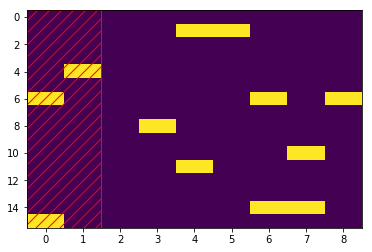

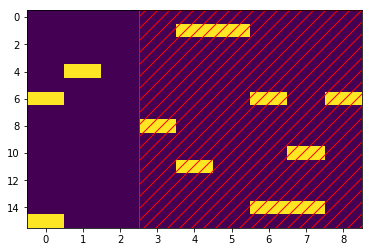

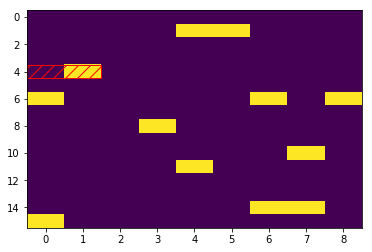

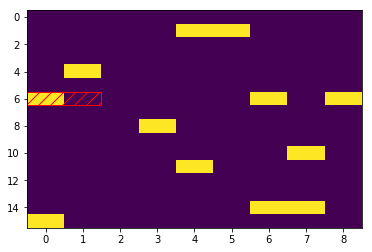

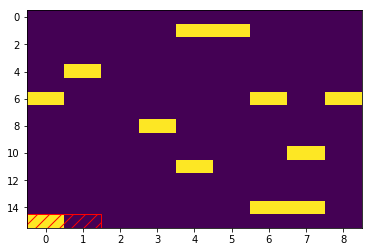

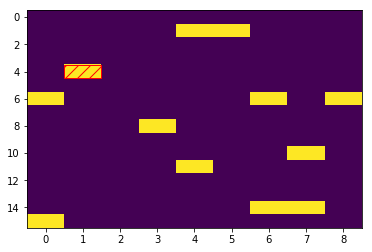

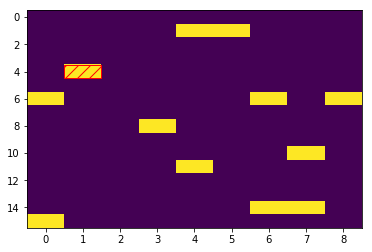

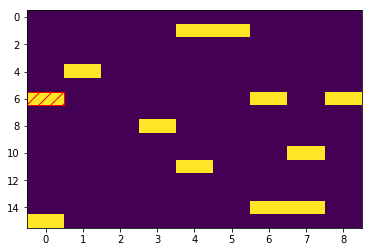

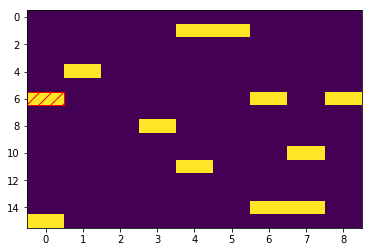

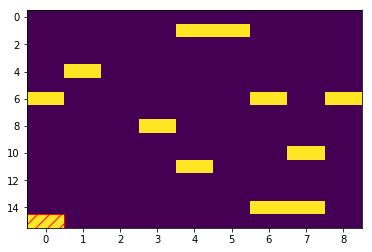

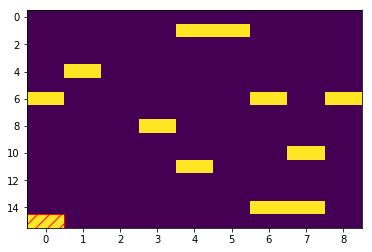

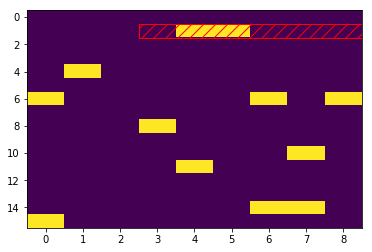

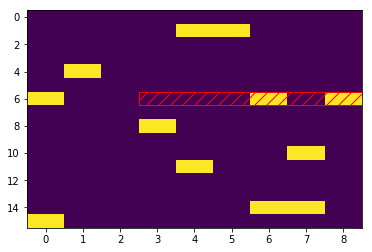

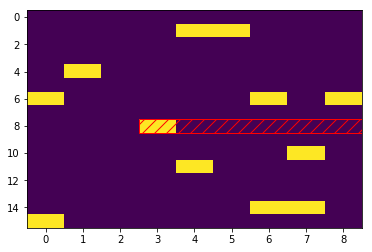

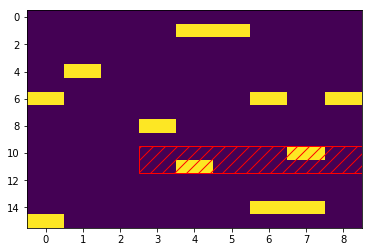

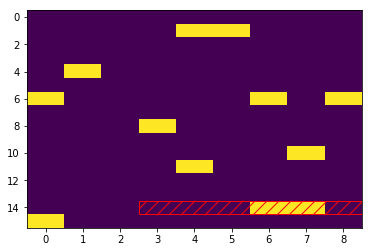

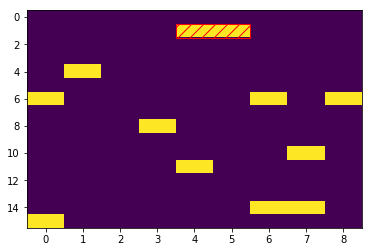

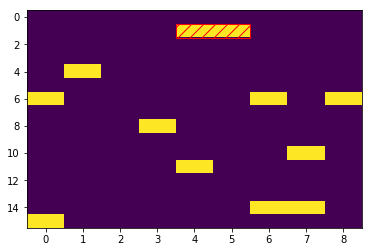

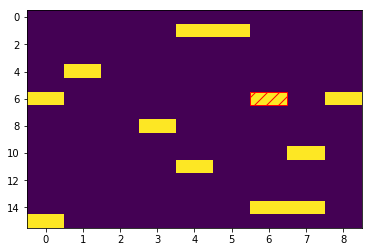

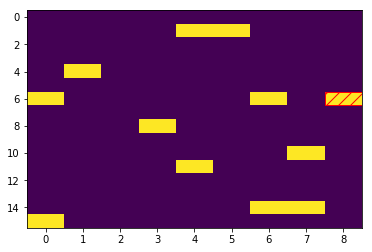

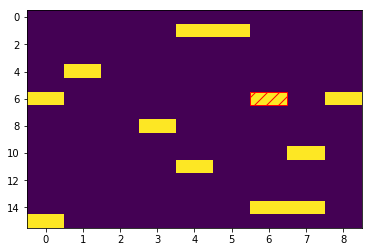

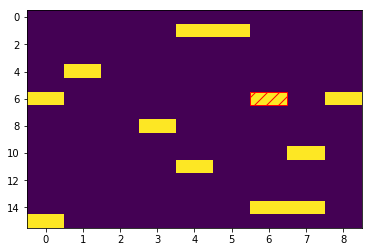

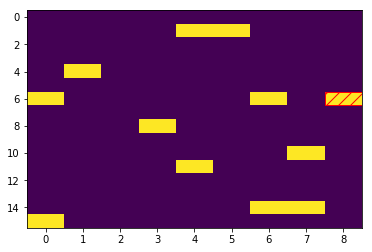

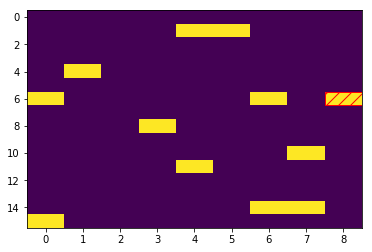

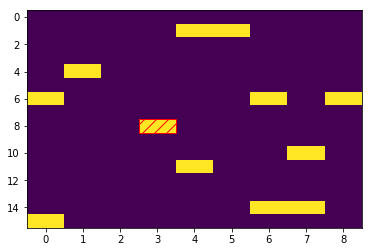

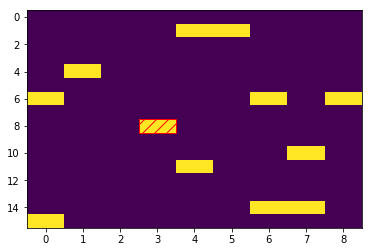

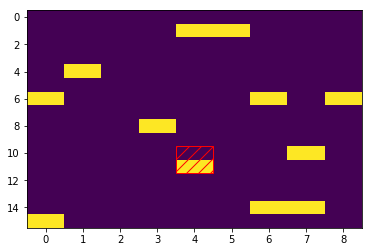

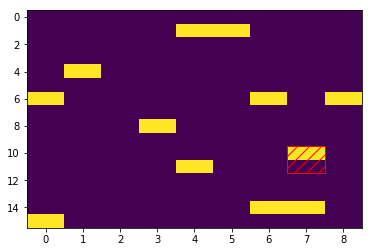

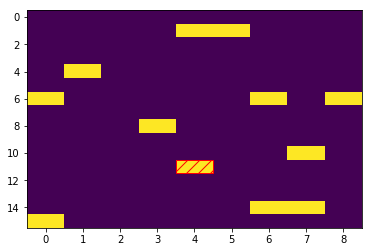

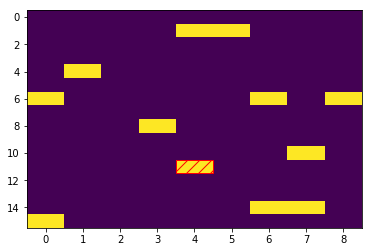

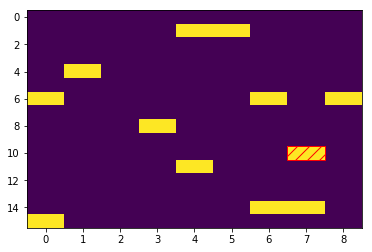

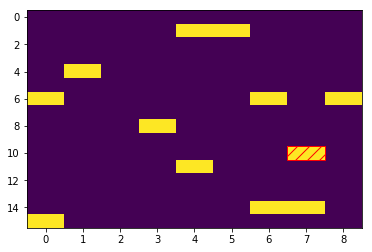

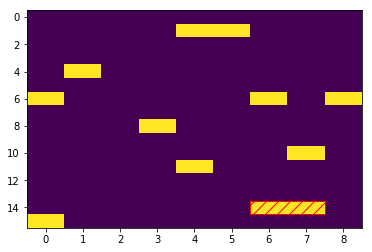

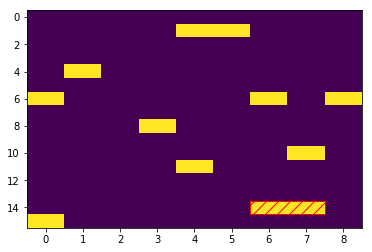

In [26]:
matches = re.findall("\[\d*, \d*, \d*, \d*\]", log_capture_string.getvalue())
for match in matches:
    array = ast.literal_eval(match)
    patch = patchfinder.patch.Patch(array[0], array[1], array[2], array[3])
    congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, [patch])

.

In [27]:
for patch in patches:
    print(patch)

xStart: 4 | xEnd: 4 | yStart: 1 | yEnd: 1
xStart: 6 | xEnd: 6 | yStart: 0 | yEnd: 0
xStart: 15 | xEnd: 15 | yStart: 0 | yEnd: 0
xStart: 1 | xEnd: 1 | yStart: 4 | yEnd: 5
xStart: 6 | xEnd: 6 | yStart: 6 | yEnd: 6
xStart: 6 | xEnd: 6 | yStart: 8 | yEnd: 8
xStart: 8 | xEnd: 8 | yStart: 3 | yEnd: 3
xStart: 11 | xEnd: 11 | yStart: 4 | yEnd: 4
xStart: 10 | xEnd: 10 | yStart: 7 | yEnd: 7
xStart: 14 | xEnd: 14 | yStart: 6 | yEnd: 7


.

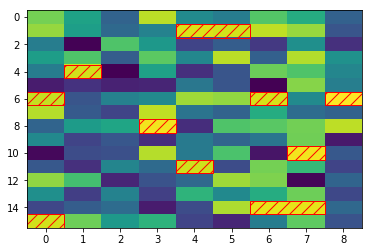

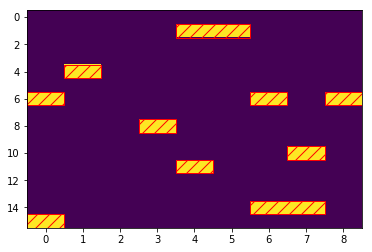

In [28]:
congestionfinder.congestion.plotCongestionsWithPatches(testDataArray, patches)
congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, patches)

.

In [29]:
patchesFiltered = patchfinder.patch.filterLargePatches(patches, 1)

2018-01-03 09:33:58,720 - DEBUG - Starting filterLargePatches()
2018-01-03 09:33:58,720 - DEBUG - Ending filterLargePatches()


.

In [30]:
for patch in patchesFiltered:
    print(patch)

xStart: 1 | xEnd: 1 | yStart: 4 | yEnd: 5
xStart: 14 | xEnd: 14 | yStart: 6 | yEnd: 7


### Congestion (part 2)

.

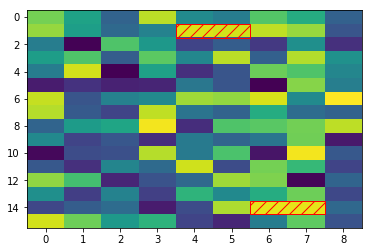

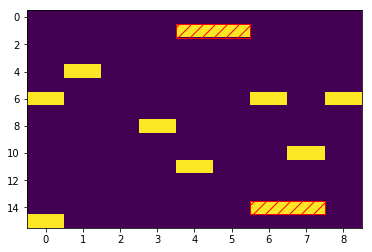

In [31]:
congestionfinder.congestion.plotCongestionsWithPatches(testDataArray, patchesFiltered)
congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, patchesFiltered)

.

In [32]:
marginSpace = 2
marginTime = 1
minSpaceIndex = 0
maxSpaceIndex = 15
minTimeIndex = 0
maxTimeIndex = 8
patchesWithMargins = congestionfinder.speedflow.addMargins(patchesFiltered, marginSpace, marginTime, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex)

2018-01-03 09:34:07,487 - DEBUG - Starting addMargins()
2018-01-03 09:34:07,487 - DEBUG - Ending addMargins()


.

In [33]:
for patch in patchesWithMargins:
    print(patch)

xStart: 0 | xEnd: 3 | yStart: 3 | yEnd: 6
xStart: 12 | xEnd: 15 | yStart: 5 | yEnd: 8


.

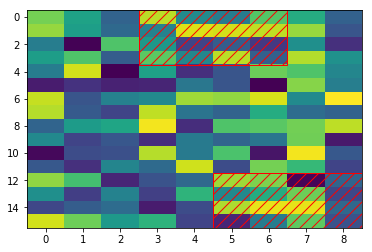

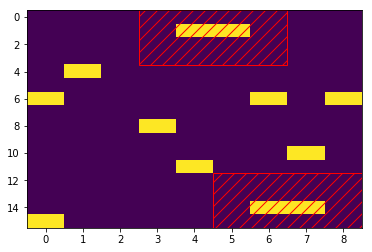

In [34]:
congestionfinder.congestion.plotCongestionsWithPatches(testDataArray, patchesWithMargins)
congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, patchesWithMargins)

TODO: Use mask to construct speed flow patches.

End of Notebook